In [201]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');

Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');


<IPython.core.display.Javascript object>

# We created attributes on Demographics, CCSP, HEDIS, TOTAL and Special health program (gold sneakers)

###### AGE-  The Medicare and Mediaid depends upon age. A patient is categorised into one of this category based on Age

In [202]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
df= pd.read_csv('2020_Competition_Training (1).csv')
# df = pd.read_csv('2020_Competition_Holdout .csv')
# df['transportation_issues'] = 0

In [203]:
df.shape

(69572, 826)

In [204]:
### Demographic Variables
'''sdr_person_id
sex_cd
smoker_current_ind
smoker_former_ind
transportation_issues
est_age

cons_cmys
cons_hcaccprf_h
cons_hcaccprf_p
cons_hhcomp
cons_homstat
cons_n2029_y
cons_n2mob
cons_n2pbl
cons_n2pmv
cons_n65p_y
cons_online_buyer
cons_ret_y
cons_retail_buyer
cons_veteran_y
rucc_category'''


# cnty_cd
# Zip_cd
# state_cd
# cnty_cd
# lang_spoken_cd


# Probable
# cons_hhcomp
# cons_n2029_y
# cons_n2mob
# cons_n2pbl
# cons_online_buyer
# cons_ret_y
# # cons_n2pmv
# 'cons_retail_buyer',
# 'cons_veteran_y',
# 'cons_n65p_y',

'sdr_person_id\nsex_cd\nsmoker_current_ind\nsmoker_former_ind\ntransportation_issues\nest_age\n\ncons_cmys\ncons_hcaccprf_h\ncons_hcaccprf_p\ncons_hhcomp\ncons_homstat\ncons_n2029_y\ncons_n2mob\ncons_n2pbl\ncons_n2pmv\ncons_n65p_y\ncons_online_buyer\ncons_ret_y\ncons_retail_buyer\ncons_veteran_y\nrucc_category'

In [205]:
Demographic_Df= df.filter(items=['person_id_syn',
'sex_cd',
'smoker_current_ind',
'smoker_former_ind',
'transportation_issues',
'est_age',
'cons_cmys',
'cons_hcaccprf_h',
'cons_hcaccprf_p',
'cons_homstat',
'cons_online_buyer',
'rucc_category'])

In [206]:
def smote_fn(X,y):
    from imblearn.over_sampling import SMOTE

    # Oversample with SMOTE and random undersample for imbalanced dataset
    from collections import Counter
    from sklearn.datasets import make_classification
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline
    from matplotlib import pyplot
    from numpy import where

    # summarize class distribution
    counter = Counter(y)
    print(counter)
    # define pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.9)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y)
    print(counter)
    return X, y

In [207]:
def logistic(X_train, X_test,y_train, y_test):
    logistic_regression= LogisticRegression()
    logistic_regression.fit(X_train,y_train)
    y_pred_test=logistic_regression.predict(X_test)
    y_pred_train=logistic_regression.predict(X_train)
    return logistic_regression,y_pred_train, y_pred_test
    

In [208]:
def Balanced_bagging(X_train, X_test,y_train, y_test):
    from imblearn.ensemble import BalancedBaggingClassifier
    from sklearn.tree import DecisionTreeClassifier
    #Create an object of the classifier.
    bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=True,
                                    random_state=0)


    #Train the classifier.
    bbc.fit(X_train, y_train)
    y_pred_train = bbc.predict(X_train)
    y_pred_test = bbc.predict(X_test)
    
    return bbc, y_pred_train, y_pred_test

In [209]:
def metrics_fn(model, y_train, y_test, y_pred_train, y_pred_test):
    from sklearn.metrics import confusion_matrix,accuracy_score
    from cf_matrix import make_confusion_matrix
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_test))
    print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_train))
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4) # for label size
    make_confusion_matrix(cm, group_names=['no- issue','issue'],categories=['no-issue','issue'], cmap='binary')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) 
    plt.show()
    
    
    

    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    # preds = [1]*17119
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [210]:
def xgboost_fn(X_train, X_test, y_train, y_test):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    # Hyperparameter tuning grid
    params = {'min_child_weight': [5],
            'gamma': [1.5],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'max_depth': [4]}

    from sklearn.model_selection import GridSearchCV
    from xgboost.sklearn import XGBClassifier
    # Initialize XGBoost model, use growth tree algorithm similar to lightgbm
    bst = XGBClassifier(n_jobs=-1,grow_policy='lossguide',tree_method ='hist',n_estimators=150)
    # Gridsearch on parameter grid, use AUC to determine the best model
    cv = GridSearchCV(bst,params,'roc_auc',-1, verbose=10)
    # Fit model on the training data, track logloss on training and testing set
    cv.fit(X_train, y_train,eval_metric='logloss',eval_set=[(X_train,y_train),(X_test,y_test)],verbose=False)

    import cf_matrix
    from cf_matrix import make_confusion_matrix
    from sklearn.metrics import confusion_matrix,accuracy_score

    y_xg_pred_test = cv.best_estimator_.predict(X_test)
    y_xg_pred_train = cv.best_estimator_.predict(X_train)

    print(metrics.accuracy_score(y_test, y_xg_pred_test))
    print(metrics.accuracy_score(y_train, y_xg_pred_train))


    cm = confusion_matrix(y_test, y_xg_pred_test)
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4) # for label size
    make_confusion_matrix(cm, group_names=['no- issue','issue'],categories=['no-issue','issue'], cmap='binary')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) 
    plt.show()

    import joblib

    # Print out the best parameters
    cv.best_params_

    #save model
    joblib.dump(cv.best_estimator_, 'xgb.model')


    #load saved model
    xgb = joblib.load('xgb.model')


    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    probs = xgb.predict_proba(X_test)
    preds = probs[:,1]
    # preds = [1]*17119
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


    # retrieve performance metrics
    results = xgb.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss');

    # Feature importance plot
    feature_importance = pd.DataFrame({'feature':xgb.get_booster().feature_names, 'importance':xgb.feature_importances_}).sort_values('importance',ascending=False).reset_index().drop(columns='index')
    fig, ax = plt.subplots()
    fig.set_size_inches(8.27,15)
    plt.title('Feature Importance Plot')
    sns.barplot(x='importance',y='feature',ax=ax,data=feature_importance[:50])
    return feature_importance


In [211]:
def train_test_split_fn(df):
    y = df['transportation_issues']
    X = df.drop(['transportation_issues','person_id_syn'],axis=1)

    
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    import seaborn as sn
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler

    # y = Demographic_Df['transportation_issues']
    # X = Demographic_Df[['est_age']]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

    X_train.reset_index(inplace=True,drop=True)
    X_test.reset_index(inplace=True,drop=True)
    y_train.reset_index(inplace=True,drop=True)
    y_test.reset_index(inplace=True,drop=True)
    
    return X_train, X_test, y_train, y_test

In [212]:
def plot_categorical(i,df):
    fig,ax = plt.subplots()
    fig.set_size_inches(18,7)

    ax = sns.countplot(x=i, hue="transportation_issues", data=df)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 1.9, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.show()
    

In [228]:
def numerical_plotting(i,df):
    fig,ax = plt.subplots()
    fig.set_size_inches(18,7)
    df['transportation_issues'] = df.transportation_issues.map({0:'no',1:'yes'})
    df.groupby([i, 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False,rot=90,ax=ax)
    plt.rcParams.update({'font.size': 10})
    plt.tick_params(labelsize=14)
    plt.show()

In [214]:
def label_encoder_fn(df, categorical_columns, numerical_columns):
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    from collections import defaultdict
    d = defaultdict(LabelEncoder)
    from collections import defaultdict
    d = defaultdict(LabelEncoder)
    df_cat = df[categorical_columns].apply(lambda x: d[x.name].fit_transform(x))
    df_num = df[numerical_columns]
    df_all = pd.concat([df_num,df_cat],axis=1)
    
    return df_all

In [230]:
Demographic_Df= df.filter(items=['person_id_syn',
'sex_cd',
'smoker_current_ind',
'smoker_former_ind',
'transportation_issues',
'est_age',
'rucc_category'])

### Age

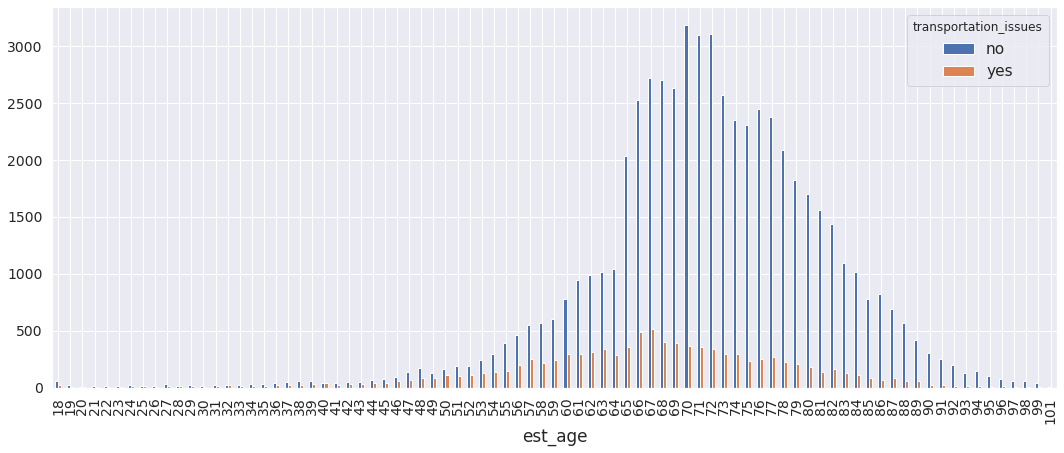

In [231]:
numerical_plotting('est_age',Demographic_Df)

In [ ]:
Demographic_Df[Demographic_Df.transportation_issues==1].est_age.mean()

In [197]:
Demographic_Df.transportation_issues.map({0:'no',1:'yes'})

0         no
1         no
2        yes
3         no
4         no
        ... 
69567     no
69568     no
69569     no
69570     no
69571    yes
Name: transportation_issues, Length: 69572, dtype: object

In [125]:
Demographic_Df[Demographic_Df.transportation_issues==0].est_age.mean()

71.60176842105263

###  sex

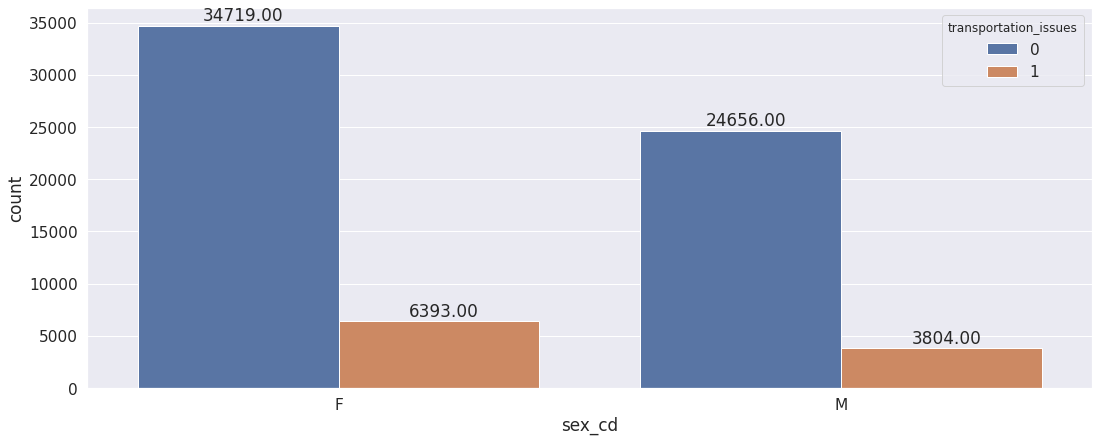

In [126]:
plot_categorical('sex_cd',df)
Demographic_Df['sex_cd'] = Demographic_Df.sex_cd.map({'M':1,'F':0})
Demographic_Df['sex_cd'] = Demographic_Df.sex_cd.astype('category')

In [127]:
(34719+6393)/6393

6.430783669638667

In [128]:
(24656+3804)/3804

7.481598317560462

In [129]:
df_sex = df[['transportation_issues','sex_cd']]

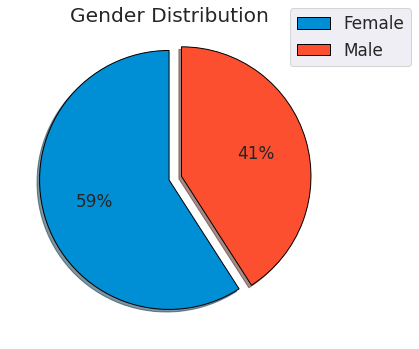

In [130]:
IAP = df['sex_cd'].value_counts().to_frame().T

fig, ax = plt.subplots()
labels = 'Female', 'Male'
colors = ['#008fd5', '#fc4f30']
explode = (0, 0.1)
explode2 = (0.2, 0)

# plt.title('Pie chart per CTQ-tool')
plt.tight_layout()

ax.pie(IAP.iloc[[0]], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=explode, shadow=True)


# fig.suptitle('distribution of dependent variable', fontsize=20, y=1.07, fontweight='bold', x=0.37)
fig.set_figheight(5)
fig.set_figwidth(7)
fig.suptitle("Gender Distribution")
fig.legend(loc='best', labels=labels, fontsize='medium')
fig.tight_layout()

In [131]:
df_sex.sex_cd.value_counts()

F    41112
M    28460
Name: sex_cd, dtype: int64

### Smoker

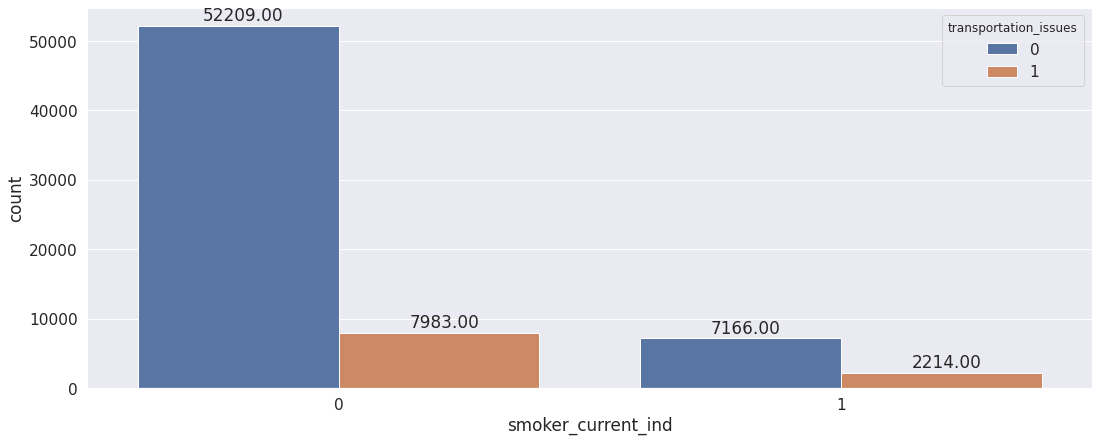

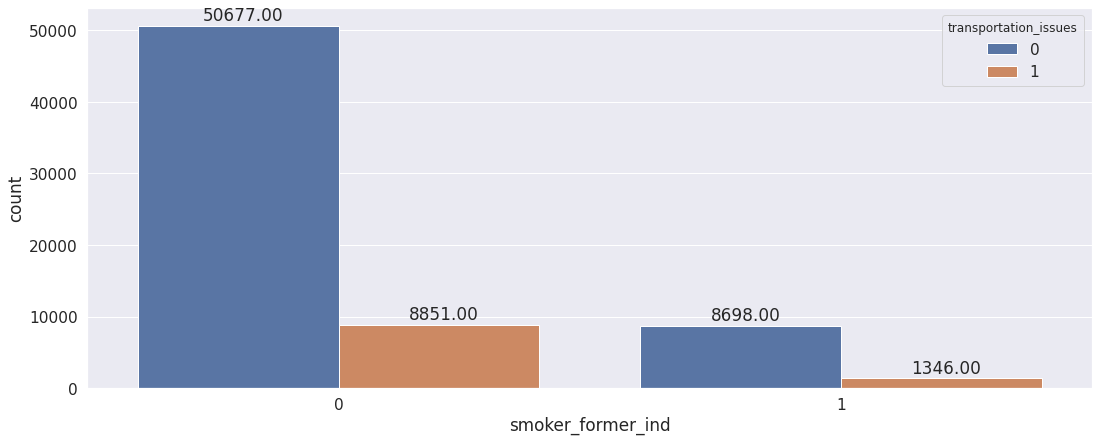

In [132]:
plot_categorical('smoker_current_ind',Demographic_Df)
Demographic_Df['smoker_current_ind'] = Demographic_Df.smoker_current_ind.astype('category')

plot_categorical('smoker_former_ind',Demographic_Df)

Demographic_Df['smoker_former_ind'] = Demographic_Df.smoker_former_ind.astype('category')

In [133]:
7.5+4.2

11.7

In [134]:
(52209+7983)/7983

7.540022547914318

In [135]:
(7166+2214)/2214

4.236675700090334

## former smoker

In [136]:
(50677+8851)/8851

6.725567732459609

In [137]:
(8698+1346)/1346

7.462109955423477

## Rural _Urban

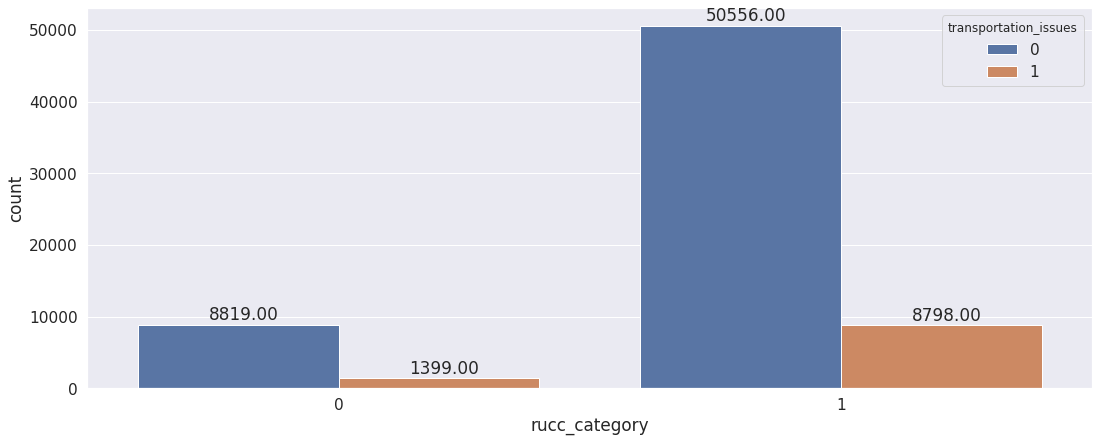

In [138]:
Demographic_Df['rucc_category'].replace('-','_',inplace=True)
Demographic_Df['rucc_category'] = Demographic_Df.rucc_category.str.replace('-Metro','')
Demographic_Df['rucc_category'] = Demographic_Df.rucc_category.str.replace('-Nonmetro','')
Demographic_Df['rucc_category'] = Demographic_Df.rucc_category.astype('category')
Demographic_Df['rucc_category'] = Demographic_Df.rucc_category.astype(int)
Demographic_Df.loc[Demographic_Df.rucc_category <=3, 'rucc_category'] = 1
Demographic_Df.loc[Demographic_Df.rucc_category >3, 'rucc_category'] = 0
Demographic_Df['rucc_category'] = Demographic_Df.rucc_category.astype('category')


plot_categorical('rucc_category',Demographic_Df)

In [139]:
(8819+1399)/1399

7.303788420300214

In [140]:
(50556+ 8798)/8798

6.746305978631507

In [141]:
for i in ['sex_cd', 'smoker_current_ind', 'smoker_former_ind','transportation_issues', 'rucc_category']:
    Demographic_Df[i] = Demographic_Df[i].astype('category')
    

categorical_columns = Demographic_Df.select_dtypes(include='category').columns
numerical_columns = Demographic_Df.select_dtypes(exclude='category').columns

In [142]:
categorical_columns

Index(['sex_cd', 'smoker_current_ind', 'smoker_former_ind',
       'transportation_issues', 'rucc_category'],
      dtype='object')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


0.84924969815443
0.8549224783916901


<Figure size 1440x1080 with 0 Axes>

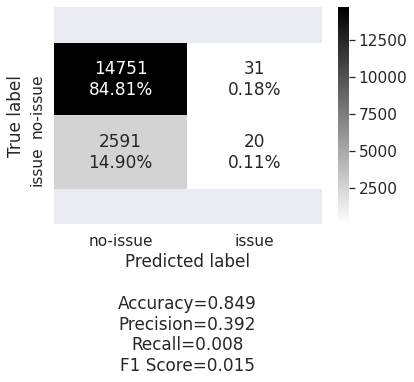

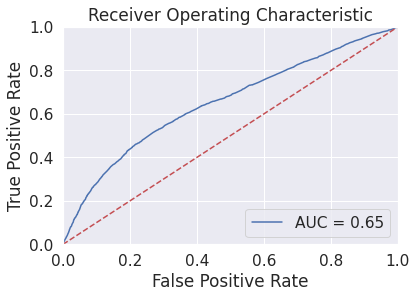

,feature,importance
0,smoker_current_ind,0.356091
1,est_age,0.342708
2,sex_cd,0.130652
3,rucc_category,0.104176
4,smoker_former_ind,0.066373


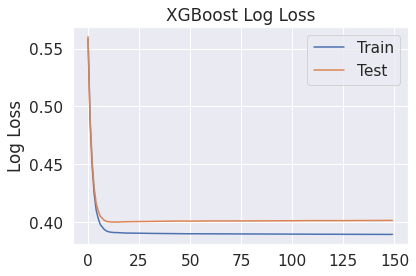

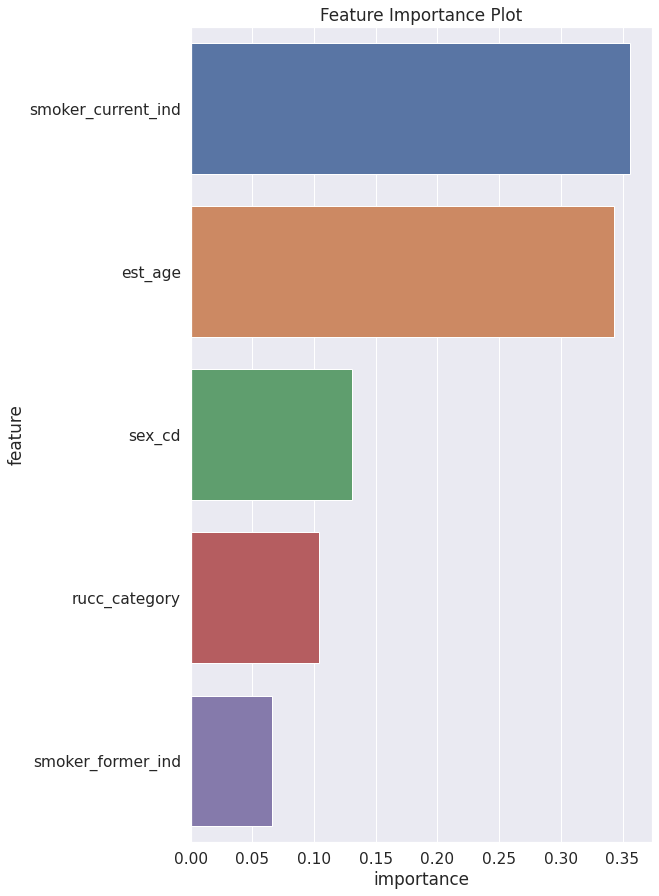

In [143]:
Demographic_Df_all = label_encoder_fn(Demographic_Df, categorical_columns, numerical_columns)

X_train, X_test, y_train, y_test = train_test_split_fn(Demographic_Df_all)

xgboost_fn(X_train, X_test, y_train, y_test)

In [144]:
df_all = Demographic_Df[['sex_cd', 'smoker_current_ind', 'smoker_former_ind',
       'transportation_issues', 'rucc_category','est_age','person_id_syn']]

In [145]:
df_all.shape

(69572, 7)

# CCSP

CCSP - Clinical Classification Software - It is a tool used to cluster patients diagnosis and procedure into
categories

The type of 

betos and ccsp relation eg - if a person has gone through oncology in betos ((P7B) does that person has a value in CCSP in 14, 20, 21, 34


http://health.utah.gov/opha/IBIShelp/codes/CCS.htm in

In [146]:
CCSP_columns  = [s for s in df if 'ccsp' in s]
df_CCSP = pd.concat([df[CCSP_columns],df[['person_id_syn','transportation_issues']]],axis=1)
for i in CCSP_columns:
    df_CCSP[i] = df_CCSP[i].astype('category')
    df_one = df_CCSP[df_CCSP[i]==1]
    print("percentage of ",i, 'as Yes is', df_one.shape[0]/df_CCSP.shape[0])
    try:
        print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])
    except:
        continue
    print('-'*30)

    
df_CCSP['CCSP_sum'] = df_CCSP[CCSP_columns].sum(axis=1) 
df_CCSP['transportation_issues'] = df_CCSP['transportation_issues'].astype('category')
df_one = df_CCSP[df_CCSP['CCSP_sum']>0]
print("percentage of ",'CCSP_sum', 'as Yes is', df_one.shape[0]/df_CCSP.shape[0])
print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])


percentage of  ccsp_014_ind as Yes is 0.008509170355890302
percentage of YES and Transportation Issue 0.17229729729729729
------------------------------
percentage of  ccsp_020_ind as Yes is 0.01895877651928937
percentage of YES and Transportation Issue 0.14935557240333586
------------------------------
percentage of  ccsp_021_ind as Yes is 0.0010492726959121486
percentage of YES and Transportation Issue 0.136986301369863
------------------------------
percentage of  ccsp_034_ind as Yes is 0.0
percentage of  ccsp_060_ind as Yes is 0.0008336687173000633
percentage of YES and Transportation Issue 0.20689655172413793
------------------------------
percentage of  ccsp_062_ind as Yes is 0.059089863738285515
percentage of YES and Transportation Issue 0.16565312576015567
------------------------------
percentage of  ccsp_080_ind as Yes is 0.0009630311044673144
percentage of YES and Transportation Issue 0.1791044776119403
------------------------------
percentage of  ccsp_107_ind as Yes is 0.0

In [147]:
df_CCSP.loc[df_CCSP['CCSP_sum'] >0, 'CCSP_yes_no'] = 1
df_CCSP['CCSP_yes_no'] = df_CCSP['CCSP_yes_no'].fillna(0)   


In [148]:
df_CCSP[df_CCSP.CCSP_sum == df_CCSP.CCSP_sum.max()]

,ccsp_014_ind,ccsp_020_ind,ccsp_021_ind,ccsp_034_ind,ccsp_060_ind,ccsp_062_ind,ccsp_080_ind,ccsp_107_ind,ccsp_120_ind,ccsp_125_ind,...,ccsp_212_ind,ccsp_220_ind,ccsp_228_ind,ccsp_236_ind,ccsp_239_ind,ccsp_242_ind,person_id_syn,transportation_issues,CCSP_sum,CCSP_yes_no
50705,1,1,0,0,0,1,0,0,0,0,...,0,1,1,1,1,0,MeO86ca81eS2T910La4YdAI7,0,8.0,1.0


In [149]:
df_ccsp_subset = df_CCSP[['ccsp_239_ind',
 'ccsp_220_ind',
 'ccsp_236_ind',
 'ccsp_163_ind',
 'ccsp_228_ind',
 'ccsp_107_ind']]

for i in df_ccsp_subset.columns:
    df_ccsp_subset[i] = df_ccsp_subset[i].astype('category')

In [150]:
df_visualize = pd.concat([df_ccsp_subset,df[['transportation_issues']]],axis=1)
# df_visualize = df_visualize.groupby(['transportation_issues']).sum().transpose()

# df_visualize.reset_index(drop=False,inplace=True)
# df_visualize.columns = ['sum_columns','no_issues','issues']

## out of all those patintes who used the category, how many of them had transportation issues

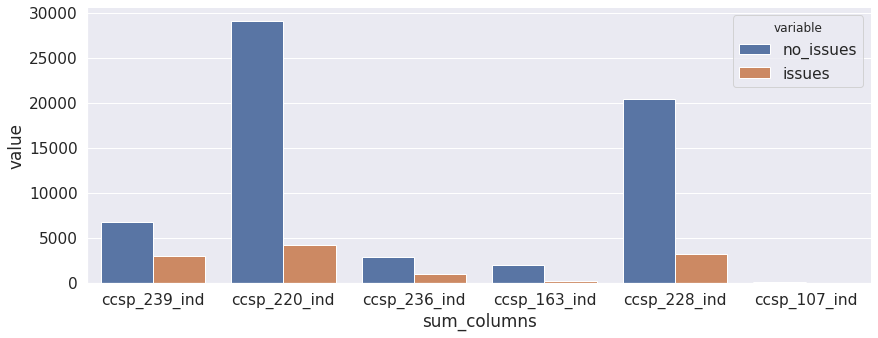

In [151]:
df_visualize = pd.concat([df_ccsp_subset,df[['transportation_issues']]],axis=1)
df_visualize = df_visualize.groupby(['transportation_issues']).sum().transpose()
df_visualize.reset_index(drop=False,inplace=True)
df_visualize.columns = ['sum_columns','no_issues','issues']

df_visualize = df_visualize.melt(['sum_columns'])

ax = sns.catplot(x="sum_columns", y="value", hue="variable", kind="bar",height=5, 
            aspect=2.5, data=df_visualize,legend_out=False)
# ax.title("asdf")

In [152]:
# df_visualize.to_csv("df_ccsp_viz.csv",index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


0.8498821364916921
0.854673336016405


<Figure size 1440x1080 with 0 Axes>

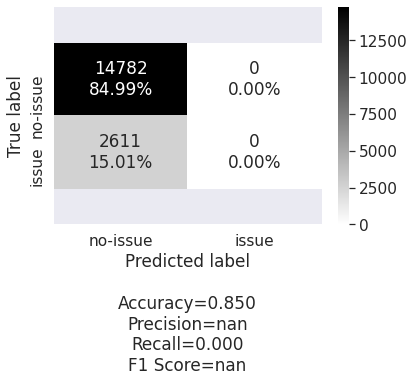

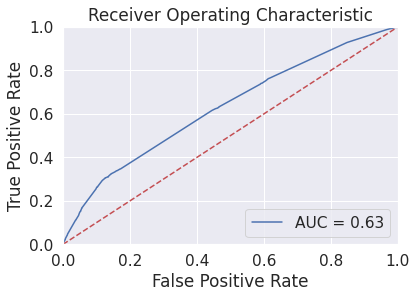

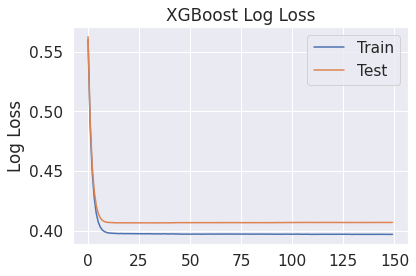

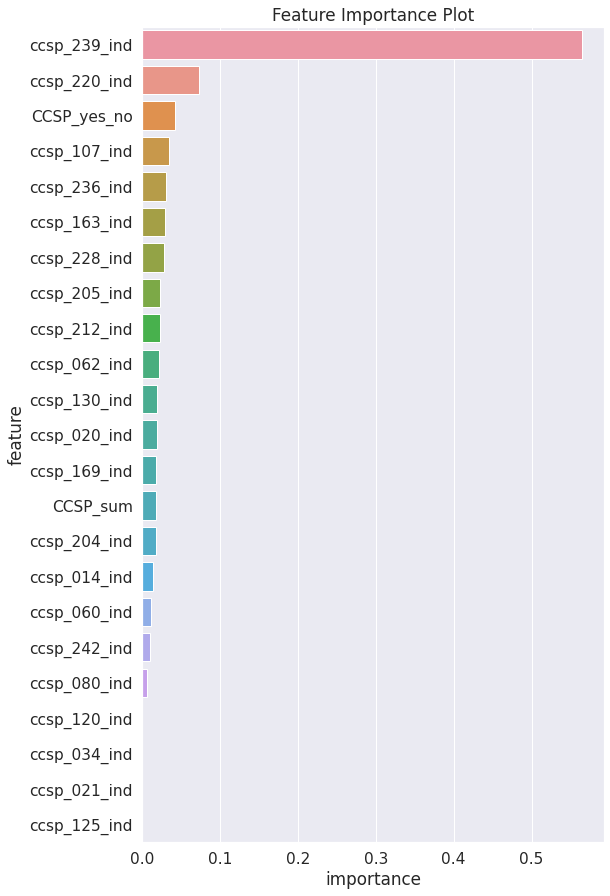

In [153]:
categorical_columns = df_CCSP.select_dtypes(include='category').columns
# categorical_columns = list(categorical_columns) + ['transportation_issues']
numerical_columns = df_CCSP.select_dtypes(exclude='category').columns

df_CCSP_encoded = label_encoder_fn(df_CCSP, categorical_columns, numerical_columns)

# Demographic_Df_all = Demographic_Df_all.join(df_CCSP, lsuffix='person_id_syn', rsuffix='person_id_syn_CCSP')
# Demographic_Df_all.drop(['person_id_syn_CCSP'],axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split_fn(df_CCSP_encoded)

feature_importancs = xgboost_fn(X_train, X_test, y_train, y_test)

In [154]:
# top_featured_columns = list(feature_importancs.feature)[0:8]

In [155]:
top_featured_columns = ['ccsp_239_ind',
 'ccsp_220_ind',
 'ccsp_236_ind',
 'ccsp_163_ind',
 'ccsp_228_ind',
 'ccsp_107_ind',
 'ccsp_205_ind',
 'CCSP_sum',
 'person_id_syn_CCSP']

In [156]:
# df_CCSP = df_CCSP[top_featured_columns]

In [157]:
df_CCSP = df_CCSP.rename(columns={'person_id_syn': 'person_id_syn_CCSP'})
df_all = pd.merge(df_all, df_CCSP[top_featured_columns], left_on='person_id_syn', right_on='person_id_syn_CCSP', how='left')

df_all.drop('person_id_syn_CCSP',axis=1,inplace=True)

In [158]:
#feature_importancs.feature

In [159]:
#df_CCSP['CCSP_sum'] = df_CCSP.CCSP_sum.astype('category')
#for i in feature_importancs.feature[0:2]:
#(CCSP_sum,df_CCSP)

## HEDIS

In [160]:
# HEDIS_columns = [s for s in df.columns if 'hedis' in s]
# HEDIS_columns.append('transportation_issues')
# HEDIS_columns.append('person_id_syn')
# df_hedis = df[HEDIS_columns]
# df_hedis.isna().sum()
# df_hedis=df_hedis.drop(columns=['hedis_ami','hedis_cmc_ldc_c_control','hedis_cmc_ldc_c_screen'])
# # df_hedis=df_hedis.dropna()
# for i in df_hedis.columns:
#     df_hedis[i] = df_hedis[i].map({'Y': 1, 'N': 0})
    
# for i in df_hedis.columns:
#     if i== 'person_id_syn':
#         continue
#     else:
#         df_hedis[i] = df_hedis[i].astype('category')
#         df_one = df_hedis[df_hedis[i]==1]
#         print("percentage of ",i, 'as Yes is', df_one.shape[0]/df_hedis.shape[0])
#         print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_hedis.shape[0])
#         print('-'*30)

In [161]:
# # df_hedis = df_hedis.rename(columns={'person_id_syn': 'person_id_syn_hedis'})
# categorical_columns = df_hedis.select_dtypes(include='category').columns
# numerical_columns = df_hedis.select_dtypes(exclude='category').columns
# df_hedis = label_encoder_fn(df_hedis, categorical_columns, numerical_columns)
# df_hedis=df_hedis[['hedis_dia_ldc_c_screen','hedis_dia_eye','person_id_syn_hedis']]
# # Demographic_Df_all = Demographic_Df_all.join(df_hedis, lsuffix='person_id_syn', rsuffix='person_id_syn_hedis')
# # Demographic_Df_all.drop(['person_id_syn_hedis'],axis=1,inplace=True)
# # Demographic_Df_all=Demographic_Df_all.dropna()

In [162]:
# X_train, X_test, y_train, y_test = train_test_split_fn(Demographic_Df_all)
# xgboost_fn(X_train, X_test, y_train, y_test)

In [163]:
df_all.dtypes

sex_cd                   category
smoker_current_ind       category
smoker_former_ind        category
transportation_issues    category
rucc_category            category
est_age                     int64
person_id_syn              object
ccsp_239_ind             category
ccsp_220_ind             category
ccsp_236_ind             category
ccsp_163_ind             category
ccsp_228_ind             category
ccsp_107_ind             category
ccsp_205_ind             category
CCSP_sum                  float64
dtype: object

# TOTAL

In [177]:
len(TOTAL_columns)

17

In [178]:
TOTAL_columns

['total_ambulance_visit_ct_pmpm',
 'total_er_visit_ct_pmpm',
 'total_ip_acute_admit_ct_pmpm',
 'total_ip_acute_admit_days_pmpm',
 'total_ip_ltach_admit_ct_pmpm',
 'total_ip_ltach_admit_days_pmpm',
 'total_ip_maternity_admit_ct_pmpm',
 'total_ip_maternity_admit_days_pmpm',
 'total_ip_mhsa_admit_ct_pmpm',
 'total_ip_mhsa_admit_days_pmpm',
 'total_ip_rehab_admit_ct_pmpm',
 'total_ip_rehab_admit_days_pmpm',
 'total_ip_snf_admit_ct_pmpm',
 'total_ip_snf_admit_days_pmpm',
 'total_outpatient_visit_ct_pmpm',
 'total_physician_office_visit_ct_pmpm',
 'total_urgent_care_visit_ct_pmpm']

In [164]:
TOTAL_columns = [s for s in df if 'total_' in s]

df_TOTAL = df[TOTAL_columns]
df_TOTAL = pd.concat([df_TOTAL,df[['transportation_issues','person_id_syn']]],axis=1)


for i in TOTAL_columns:
#     sns.distplot(df_TOTAL[i])
    df_one = df_TOTAL[df_TOTAL[i] !=0]
#     col_name = i + '_ind'
    col_name = i.split("_")[:-1]
    col_name = "_".join(col_name) + '_ind'
    df_TOTAL[col_name] = 0
    df_TOTAL[col_name][df_TOTAL[i] != 0 ] = 1
    df_TOTAL[col_name] = df_TOTAL[col_name].astype('category')
    print("percentage of patients having something in ",i,df_one.shape[0]/df.shape[0])
    try:
        print("percentage of YES and TOTAL Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])
    except:
        continue
#     print('-'*30)
    plt.show()
    print('-'*30)
    

df_TOTAL['TOTAL_pmpm_sum'] = df_TOTAL[TOTAL_columns].sum(axis=1)
ind_columns = [s for s in df_TOTAL if '_ind' in s]
df_TOTAL['TOTAL_ind_sum'] = df_TOTAL[ind_columns].sum(axis=1)
df_TOTAL['transportation_issues'] = df_TOTAL.transportation_issues.astype('category')
df_TOTAL['TOTAL_pmpm_sum'] = df_TOTAL[TOTAL_columns].sum(axis=1)


percentage of patients having something in  total_ambulance_visit_ct_pmpm 0.13371758753521532
percentage of YES and TOTAL Issue 0.30248306997742663
------------------------------
percentage of patients having something in  total_er_visit_ct_pmpm 0.2295607428275743
percentage of YES and TOTAL Issue 0.2102560891616054
------------------------------
percentage of patients having something in  total_ip_acute_admit_ct_pmpm 0.10229690105214742
percentage of YES and TOTAL Issue 0.2082338063790923
------------------------------
percentage of patients having something in  total_ip_acute_admit_days_pmpm 0.09983901569596965
percentage of YES and TOTAL Issue 0.20860927152317882
------------------------------
percentage of patients having something in  total_ip_ltach_admit_ct_pmpm 0.0
percentage of patients having something in  total_ip_ltach_admit_days_pmpm 0.0
percentage of patients having something in  total_ip_maternity_admit_ct_pmpm 0.0
percentage of patients having something in  total_ip_mate

In [165]:
total_ct_pmpm = [s for s in df_TOTAL if '_ct_pmpm' in s]

df_ct_pmpm = df[total_ct_pmpm]

df_ct_pmpm['ip_ct_pmpm'] = df_TOTAL[[s for s in total_ct_pmpm if '_ip' in s]].sum(axis=1)

df_ct_pmpm = df_ct_pmpm.drop([s for s in total_ct_pmpm if '_ip' in s],axis=1)

df_ct_pmpm.columns = ['ambulance','er','outpatient','physician','urgent_care','inpatient']

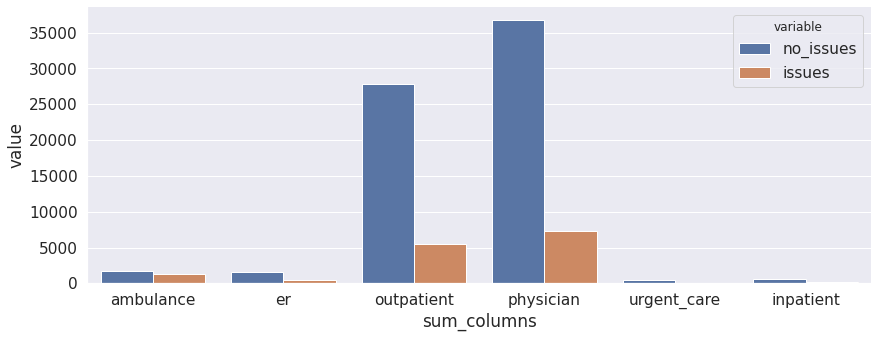

In [166]:
df_visualize = pd.concat([df_ct_pmpm,df[['transportation_issues']]],axis=1)
df_visualize = df_visualize.groupby(['transportation_issues']).sum().transpose()
df_visualize.reset_index(drop=False,inplace=True)
df_visualize.columns = ['sum_columns','no_issues','issues']

df_visualize = df_visualize.melt(['sum_columns'])

ax = sns.catplot(x="sum_columns", y="value", hue="variable", kind="bar",height=5, 
            aspect=2.5, data=df_visualize,legend_out=False)
# ax.title("asdf")

In [171]:
# df_visualize.to_csv("df_viz_util.csv")

In [179]:
27753.550670 + 5553.298718

33306.849388

In [180]:
36721.359692  + 7262.152298

43983.51199

In [169]:
df_visualize

,sum_columns,variable,value
0,ambulance,no_issues,1744.874323
1,er,no_issues,1569.929935
2,outpatient,no_issues,27753.550670
3,physician,no_issues,36721.359692
4,urgent_care,no_issues,470.297560
5,inpatient,no_issues,642.769923
6,ambulance,issues,1326.302293
7,er,issues,514.045127
8,outpatient,issues,5553.298718
9,physician,issues,7262.152298


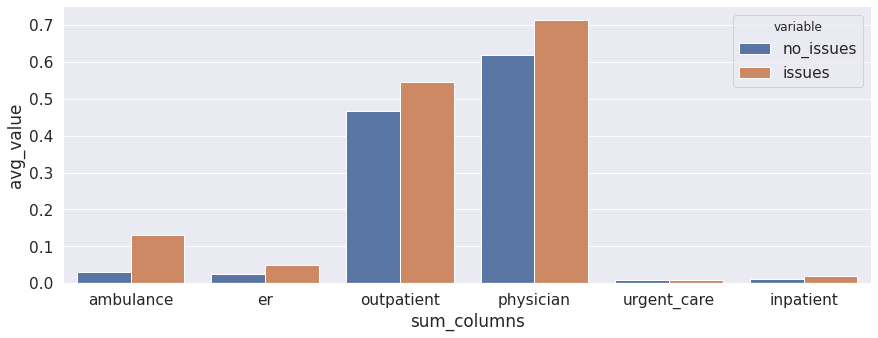

In [91]:
df_visualize['avg_value'] = 0

for index, row in df_visualize.iterrows():
    if row['variable'] == 'no_issues':
        df_visualize.loc[index,'avg_value'] = row['value']/59375
    else:
        df_visualize.loc[index,'avg_value'] = row['value']/10197
    

sns.catplot(x="sum_columns", y="avg_value", hue="variable", kind="bar",height=5, 
            aspect=2.5, data=df_visualize,legend_out=False)

In [80]:
# df_ct_pmpm = pd.concat([df_ct_pmpm,df[['transportation_issues','person_id_syn']]],axis=1)

# X_train, X_test, y_train, y_test = train_test_split_fn(df_ct_pmpm)
# feature_importance = xgboost_fn(X_train, X_test, y_train, y_test)

In [176]:
df_TOTAL['TOTAL_ind_sum'].max()

10.0

In [38]:
categorical_columns = df_TOTAL.select_dtypes(include='category').columns
numerical_columns = df_TOTAL.select_dtypes(exclude='category').columns
df_TOTAL_encoded = label_encoder_fn(df_TOTAL, categorical_columns, numerical_columns)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


0.8485022710285747
0.863738285517162


<Figure size 1440x1080 with 0 Axes>

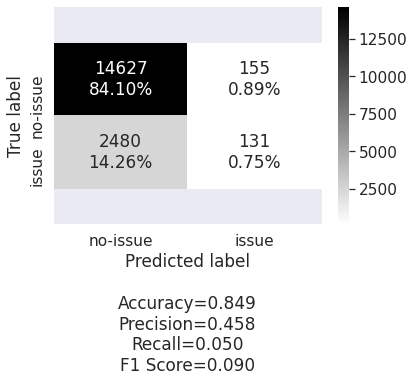

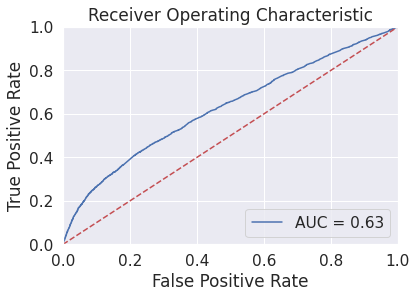

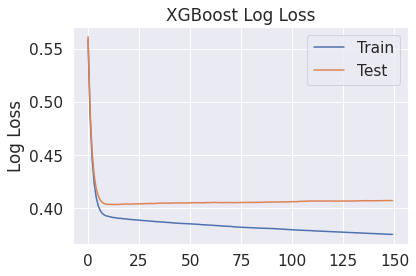

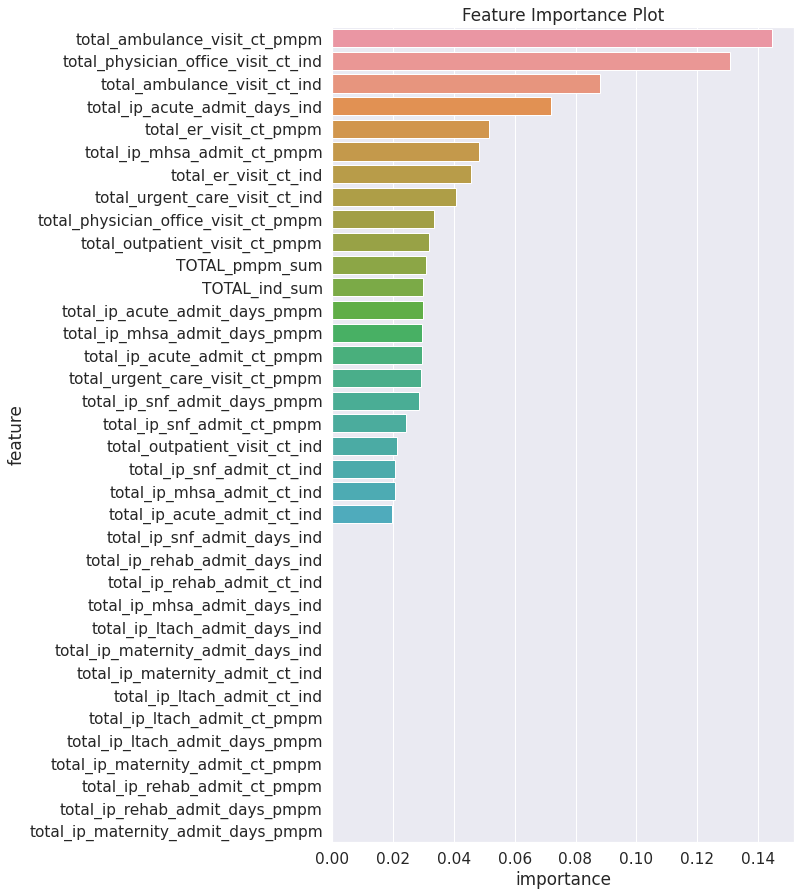

In [39]:
X_train, X_test, y_train, y_test = train_test_split_fn(df_TOTAL_encoded)
feature_importance = xgboost_fn(X_train, X_test, y_train, y_test)

In [41]:
# top_features = list(feature_importance.feature)[0:12]

In [223]:
top_features = ['total_ambulance_visit_ct_pmpm',
 'total_physician_office_visit_ct_ind',
 'total_ambulance_visit_ct_ind',
 'total_ip_acute_admit_days_ind',
 'total_er_visit_ct_pmpm',
 'total_ip_mhsa_admit_ct_pmpm',
 'total_er_visit_ct_ind',
 'total_urgent_care_visit_ct_ind',
 'total_physician_office_visit_ct_pmpm',
 'total_outpatient_visit_ct_pmpm',
 'TOTAL_pmpm_sum',
 'TOTAL_ind_sum']

In [224]:
# categorical_columns = [s for s in top_features if '_ind' in s]
# categorical_columns.remove('TOTAL_ind_sum')

# for i in categorical_columns:
#     df_TOTAL[i] = df_TOTAL[i].astype('category')

In [225]:
top_features.append('person_id_syn_TOTAL')
df_TOTAL = df_TOTAL.rename(columns={'person_id_syn': 'person_id_syn_TOTAL'})
df_all = pd.merge(df_all, df_TOTAL[top_features], left_on='person_id_syn', right_on='person_id_syn_TOTAL', how='left')
df_all.drop('person_id_syn_TOTAL',inplace=True,axis=1)

# For Train

In [194]:
df_all = df_all.rename(columns={'person_id_syn':'person_id_syn_demo'})
df_all.drop(['transportation_issues'],axis=1).to_pickle('df_demographics_suraj.pkl')

# For Test

In [226]:
df_all = df_all.rename(columns={'person_id_syn':'person_id_syn_demo'})
df_all.drop(['transportation_issues'],axis=1).to_pickle('df_demographics_suraj_test.pkl')

# For Log

In [112]:
df_all.drop('transportation_issues',axis=1).to_csv("log_df_demo.csv",index=False)

In [265]:
df_TOTAL['TOTAL_sum'] = df_TOTAL[TOTAL_columns].sum(axis=1)

df_one = df_TOTAL[df_TOTAL['TOTAL_sum']>0]
print("percentage of ",'total_sum', 'as Yes is', df_one.shape[0]/df_TOTAL.shape[0])
print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])

df_TOTAL_ind = df_TOTAL[[s for s in df_TOTAL if 'ind' in s]]
df_TOTAL_ind = df_TOTAL_ind.astype('category')
df_TOTAL_ind['TOTAL_sum'] = df_TOTAL_ind.sum(axis=1)
df_TOTAL_ind[df_TOTAL_ind.TOTAL_sum == 10]

percentage of  total_sum as Yes is 0.9674581728281493
percentage of YES and Transportation Issue 0.14573304807749451


,total_ambulance_visit_ct_ind,total_er_visit_ct_ind,total_ip_acute_admit_ct_ind,total_ip_acute_admit_days_ind,total_ip_ltach_admit_ct_ind,total_ip_ltach_admit_days_ind,total_ip_maternity_admit_ct_ind,total_ip_maternity_admit_days_ind,total_ip_mhsa_admit_ct_ind,total_ip_mhsa_admit_days_ind,total_ip_rehab_admit_ct_ind,total_ip_rehab_admit_days_ind,total_ip_snf_admit_ct_ind,total_ip_snf_admit_days_ind,total_outpatient_visit_ct_ind,total_physician_office_visit_ct_ind,total_urgent_care_visit_ct_ind,TOTAL_sum
29471,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,0,10.0


In [266]:
only_pmpm = [s for s in df_TOTAL if '_pmpm' in s]
only_ind = [s for s in df_TOTAL if '_ind' in s]
df_TOTAL_ind = df_TOTAL.drop(columns=only_pmpm)
df_TOTAL_pmpm = df_TOTAL.drop(columns=only_ind)
df_TOTAL_ind = pd.concat([df_TOTAL_ind,df[['person_id_syn']]],axis=1)
df_TOTAL_pmpm = pd.concat([df_TOTAL_pmpm,df[['person_id_syn']]],axis=1)

In [267]:
for i in df_TOTAL_ind.columns:
    if i== 'person_id_syn':
        continue
    if i== 'TOTAL_sum_ind':
        continue
    else:
        df_TOTAL_ind[i] = df_TOTAL_ind[i].astype('category')
#         df_one = df_hedis[df_hedis[i]==1]
#         print("percentage of ",i, 'as Yes is', df_one.shape[0]/df_hedis.shape[0])
#         print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_hedis.shape[0])
#         print('-'*30)

In [268]:
df_TOTAL_ind = df_TOTAL_ind.rename(columns={'person_id_syn': 'person_id_syn_Total'})
categorical_columns = df_TOTAL_ind.select_dtypes(include='category').columns
numerical_columns = df_TOTAL_ind.select_dtypes(exclude='category').columns

In [269]:
# df_TOTAL_ind = label_encoder_fn(df_TOTAL_ind, categorical_columns, numerical_columns)
# df_TOTAL_ind = df_TOTAL_ind.drop(columns=['transportation_issues'])
# df_TOTAL_ind = df_TOTAL_ind[['total_ambulance_visit_ct_ind','total_er_visit_ct_ind','total_physician_office_visit_ct_ind','total_ip_acute_admit_ct_ind','person_id_syn_Total']]

# Demographic_Df_all = Demographic_Df_all.join(df_TOTAL_ind, lsuffix='person_id_syn', rsuffix='person_id_syn_Total')
# Demographic_Df_all.drop(['person_id_syn_Total'],axis=1,inplace=True)

In [270]:
# X_train, X_test, y_train, y_test = train_test_split_fn(Demographic_Df_all)
# xgboost_fn(X_train, X_test, y_train, y_test)

In [271]:
df_TOTAL_pmpm = df_TOTAL_pmpm.rename(columns={'person_id_syn': 'person_id_syn_Total'})
categorical_columns = df_TOTAL_pmpm.select_dtypes(include='category').columns
numerical_columns = df_TOTAL_pmpm.select_dtypes(exclude='category').columns

In [272]:
df_TOTAL_pmpm = label_encoder_fn(df_TOTAL_pmpm, categorical_columns, numerical_columns)
df_TOTAL_pmpm = df_TOTAL_pmpm.drop(columns=['transportation_issues'])
df_TOTAL_pmpm = df_TOTAL_pmpm[['total_ambulance_visit_ct_pmpm', 'total_er_visit_ct_pmpm',
                               'total_outpatient_visit_ct_pmpm', 'total_physician_office_visit_ct_pmpm',
                               'total_ip_mhsa_admit_ct_pmpm',
                               'person_id_syn_Total']]

Demographic_Df_all = Demographic_Df_all.join(df_TOTAL_pmpm, lsuffix='person_id_syn', rsuffix='person_id_syn_Total')
Demographic_Df_all.drop(['person_id_syn_Total'],axis=1,inplace=True)

In [273]:
# X_train, X_test, y_train, y_test = train_test_split_fn(Demographic_Df_all)
# xgboost_fn(X_train, X_test, y_train, y_test)

In [274]:
# top_featured_columns = list(feature_importance[feature_importance.importance>0.010].feature)

# df_TOTAL = pd.concat([df_TOTAL,df[['transportation_issues']]],axis=1)

# ind_columns = [s for s in df_TOTAL if 'ind' in s]
# ind_columns.append('TOTAL_sum')

# for i in ind_columns:
#     df_one = df_TOTAL[df_TOTAL[i] ==1]
#     print("percentage of ",i, 'as Yes is', df_one.shape[0]/df_TOTAL.shape[0])
#     print("percentage of YES and TOTAL Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])
#     print('-'*30)

# only_pmpm = [s for s in df_TOTAL if '_ind' in s]
# df_TOTAL = df_TOTAL.drop(columns=only_pmpm)

# #df_TOTAL.drop('transportation_issues',axis=1).to_pickle('df_total_suraj.pkl')

# df_TOTAL = df_TOTAL.rename(columns={'person_id_syn': 'person_id_syn_Total'})
# categorical_columns = df_TOTAL.select_dtypes(include='category').columns
# #categorical_columns = list(categorical_columns) + ['transportation_issues']
# numerical_columns = df_TOTAL.select_dtypes(exclude='category').columns
# df_TOTAL = label_encoder_fn(df_TOTAL, categorical_columns, numerical_columns)
# df_TOTAL = df_TOTAL.drop(columns=['transportation_issues'])
# #df_TOTAL=df_TOTAL[['hedis_dia_ldc_c_screen','hedis_dia_eye','person_id_syn_hedis']]
# Demographic_Df_all = Demographic_Df_all.join(df_TOTAL, lsuffix='person_id_syn', rsuffix='person_id_syn_hedis')
# Demographic_Df_all.drop(['person_id_syn_Total'],axis=1,inplace=True)
# Demographic_Df_all=Demographic_Df_all.dropna()

# Demographic_Df_all

In [275]:
Demographic_Df_all.isna().sum()

person_id_syn                           0
est_age                                 0
sex_cd                                  0
smoker_current_ind                      0
smoker_former_ind                       0
transportation_issues                   0
rucc_category                           0
CCSP_sum                                0
ccsp_239_ind                            0
ccsp_220_ind                            0
ccsp_236_ind                            0
ccsp_228_ind                            0
ccsp_163_ind                            0
ccsp_169_ind                            0
hedis_dia_ldc_c_screen                  0
hedis_dia_eye                           0
total_ambulance_visit_ct_pmpm           0
total_er_visit_ct_pmpm                  0
total_outpatient_visit_ct_pmpm          0
total_physician_office_visit_ct_pmpm    0
total_ip_mhsa_admit_ct_pmpm             0
dtype: int64

In [276]:
a = np.array(Demographic_Df_all['hedis_dia_ldc_c_screen'].values.tolist())
Demographic_Df_all['hedis_dia_ldc_c_screen'] = np.where(a > 1, np.NaN, a).tolist()

a = np.array(Demographic_Df_all['hedis_dia_eye'].values.tolist())
Demographic_Df_all['hedis_dia_eye'] = np.where(a > 1, np.NaN, a).tolist()

In [277]:
cat_columns = ['sex_cd', 'smoker_current_ind','smoker_former_ind', 'transportation_issues',
               'rucc_category','ccsp_239_ind', 'ccsp_220_ind', 'ccsp_236_ind','ccsp_228_ind', 
               'ccsp_163_ind', 'ccsp_169_ind','hedis_dia_ldc_c_screen', 'hedis_dia_eye']

num_columns = ['est_age','total_ambulance_visit_ct_pmpm', 'total_er_visit_ct_pmpm',
       'total_outpatient_visit_ct_pmpm','CCSP_sum',
       'total_physician_office_visit_ct_pmpm', 'total_ip_mhsa_admit_ct_pmpm']

for i in cat_columns:
    Demographic_Df_all[i] = Demographic_Df_all[i].astype('category')
#     Demographic_Df_all[j] = Demographic_Df_all[j].astype(float)
    
# Demographic_Df_all['ccsp_236_ind'] =  Demographic_Df_all.ccsp_236_ind.astype('category')
# Demographic_Df_all['ccsp_228_ind'] =  Demographic_Df_all.ccsp_228_ind.astype('category')
# Demographic_Df_all['ccsp_163_ind'] =  Demographic_Df_all.ccsp_163_ind.astype('category')
# Demographic_Df_all['ccsp_169_ind'] =  Demographic_Df_all.ccsp_169_ind.astype('category')


Demographic_Df_all = Demographic_Df_all.rename(columns={'person_id_syn': 'person_id_syn_demo'})
Demographic_Df_all = Demographic_Df_all.drop(['transportation_issues'], axis=1)

Demographic_Df_all.drop(['hedis_dia_ldc_c_screen','hedis_dia_eye'],axis=1).to_pickle('df_demographics_suraj.pkl')

In [278]:

Demographic_Df_all.drop(['hedis_dia_ldc_c_screen','hedis_dia_eye'],axis=1).to_pickle('df_demographics_suraj.pkl')

# Health Program - hlth_pgm

hedis - Healthcare Effectiveness Data and Information Set It is used to understand how a person is performing with national data HAVE TO READ A LOT ABOUT THIS

In [63]:
# # hlth_pgm_slvrsnkr_par_status	Health program - Silver Sneakers Senior Exercise Program Participation Status
# # hlth_pgm_slvrsnkr_pct_par	Health program - Silver Sneakers Senior Exercise Program Participation Percent
# # hlth_pgm_slvrsnkr_refer_status	Health program - Silver Sneakers Senior Exercise Program Referal Status


# HLTH_columns = [s for s in df.columns if 'hlth_pgm' in s]
# df_pgm = df[HLTH_columns]
# df_pgm = pd.concat([df_pgm, df[['transportation_issues']]],axis=1)



# for i in ['hlth_pgm_slvrsnkr_par_status']:
# #     df_pgm[i] = df_pgm[i].astype('category')
#     df_one = df_pgm[df_pgm[i]==1]
#     print("percentage of ",i, 'as Yes is', df_one.shape[0]/df_pgm.shape[0])
#     print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/df_pgm.shape[0])
#     print('-'*30)
    
# df_pgm.drop(columns=['hlth_pgm_slvrsnkr_refer_status','transportation_issues','hlth_pgm_slvrsnkr_par_status'],inplace=True)


# df_pgm = pd.concat([df_pgm, df[['transportation_issues','person_id_syn']]],axis=1)
# # df_hedis_pgm.to_pickle('df_hedis_suraj.pkl')

percentage of  hlth_pgm_slvrsnkr_par_status as Yes is 0.30924797332260107
percentage of YES and Transportation Issue 0.03533030529523371
------------------------------


In [65]:
# df_pgm = df_pgm.rename(columns={'person_id_syn': 'person_id_syn_pgm'})
# df_pgm['hlth_pgm_slvrsnkr_pct_par'] = df_pgm.hlth_pgm_slvrsnkr_pct_par.astype('category')
# categorical_columns = df_pgm.select_dtypes(include='category').columns

# numerical_columns = df_pgm.select_dtypes(exclude='category').columns
# df_pgm = label_encoder_fn(df_pgm, categorical_columns, numerical_columns)
# df_pgm = df_pgm.drop(columns=['transportation_issues'])
# Demographic_Df_all = Demographic_Df_all.join(df_pgm, lsuffix='person_id_syn', rsuffix='person_id_syn_pgm')
# Demographic_Df_all.drop(['person_id_syn_pgm'],axis=1,inplace=True)
# Demographic_Df_all=Demographic_Df_all.dropna()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


0.8564752614054559
0.8670872519812294


<Figure size 1440x1080 with 0 Axes>

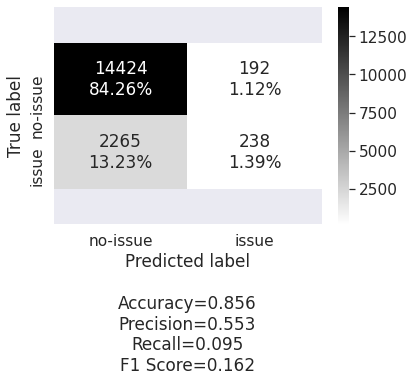

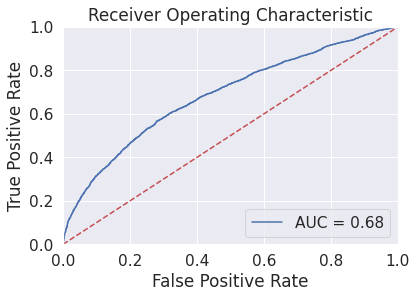

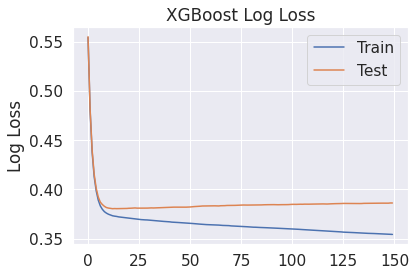

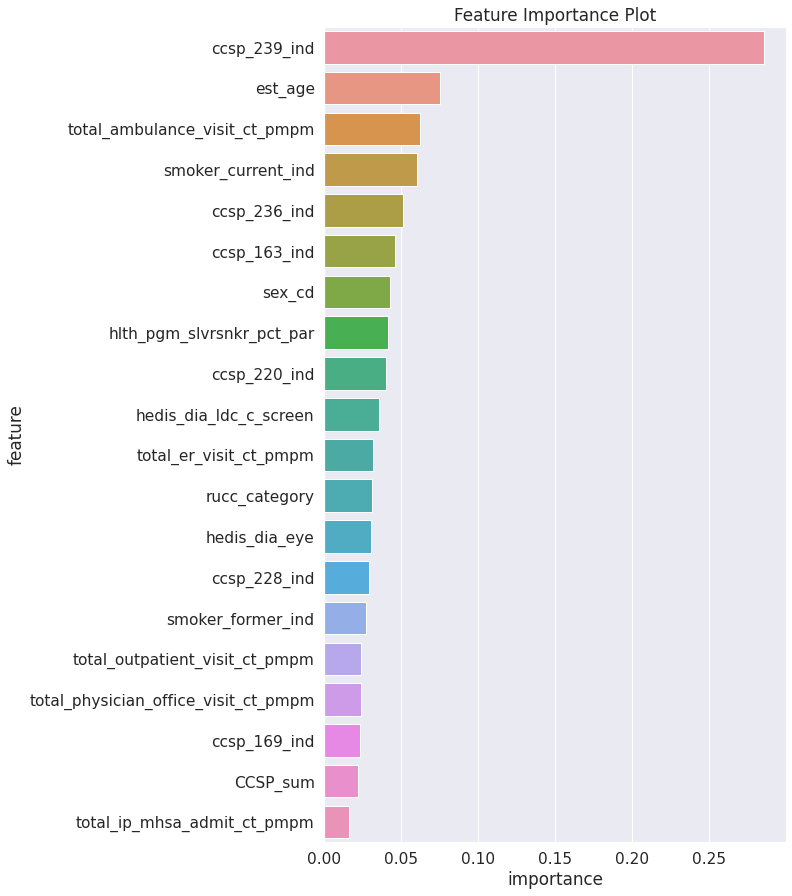

In [66]:
# X_train, X_test, y_train, y_test = train_test_split_fn(Demographic_Df_all)
# xgboost_fn(X_train, X_test, y_train, y_test)

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.connect(url="https://35.239.2818.97:54321", auth=('h2oai', '116017325225628416'))

In [ ]:
df_no_issue = Demographic_Df[Demographic_Df.transportation_issues == 0]
print(df_no_issue.shape)
df_no_issue = df_no_issue.dropna()
print("after dropping NA values",df_no_issue.shape)
df_issue = Demographic_Df[Demographic_Df.transportation_issues == 1]
df_issue = df_issue.dropna()
print("after dropping NA values",df_issue.shape)
# df_issue.isna().sum()

df_no_issues_sample = df_no_issue.sample(n=6501)
df_model_sample = pd.concat([df_no_issues_sample, df_issue])

cat_model_sample = df_model_sample.select_dtypes(include='category')
num_model_sample = df_model_sample.select_dtypes(exclude='category')

# df_model_sample = df_model_sample.drop(columns='person_id_syn')

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
from collections import defaultdict

d = defaultdict(LabelEncoder)
# Encoding the variable

from collections import defaultdict
d = defaultdict(LabelEncoder)
# Encoding the variable
cat_model_sample = cat_model_sample.apply(lambda x: d[x.name].fit_transform(x))

df_model_sample = pd.concat([num_model_sample, cat_model_sample],axis=1)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
df_model_sample

In [ ]:
y = df_model_sample['transportation_issues']
X = df_model_sample.drop(columns=['transportation_issues','person_id_syn'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred_test=logistic_regression.predict(X_test)
y_pred_train=logistic_regression.predict(X_train)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_test))
print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_train))

In [ ]:
df_model_sample.dtypes

In [ ]:
df_model_sample['transportation_issues'] = df_model_sample.transportation_issues.astype('category')

import h2o
from h2o.automl import H2OAutoML

h2o.init()
df_model_sample_hf = h2o.H2OFrame(df_model_sample)
aml = H2OAutoML(max_runtime_secs = 60)
aml.train(y= 'transportation_issues', training_frame = df_model_sample_hf)
lb = aml.leaderboard

In [ ]:
lb.head()

In [ ]:
df_model_sample.columns

In [ ]:
# We have 3696 rows having null values who has transportation issues and 15586 in which they don't have transportation issues
#in totatl its around 19k

In [ ]:
## sex_cd - Member gender	Demo	Customer Gender	 Maybe. But from graph no visible difference

In [ ]:
Demographic_Df['sex_cd'].value_counts()
#We have more number of female customers than male customers

In [ ]:
Demographic_Df.groupby(['sex_cd', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','sex_cd']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of transporation_isuues are almost similar in both males and females

In [ ]:
#sex_cd	 Member gender	Demo	Customer Gender	Maybe. But from graph no visible difference

In [ ]:
Demographic_Df['smoker_current_ind'].value_counts()
#We have less number of current Smokers in the data
Demographic_Df.groupby(['smoker_current_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False,)
#the distribution of Smokers are almost similar in both males and females
Demographic_Df.groupby(['transportation_issues','smoker_current_ind']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

In [ ]:
#smoker_former_ind	Former Smoker based on the presence of smoking indication from membership or medical claims data	Demo	Customer Previous Smoker Indicator	Maybe. But from graph no visible difference

In [ ]:
Demographic_Df['smoker_former_ind'].value_counts()
#We have less number of current Smokers than which indicates some of them  quit smoking.

In [ ]:
Demographic_Df.groupby(['smoker_former_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females
Demographic_Df.groupby(['smoker_former_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

In [ ]:
Demographic_Df.groupby(['est_age', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False,rot=90)
#the distribution of Smokers are almost similar in both males and females
##Demographic_Df.groupby(['transportation_issues','est_age']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

#From the graph we can see the transportation issues are pertinent at lesser age

In [ ]:
Demographic_Df['cons_cmys'].replace('*','',inplace=True)
Demographic_Df['cons_cmys']=pd.to_numeric(Demographic_Df['cons_cmys'])
Demographic_Df['cons_cmys'].value_counts()
Demographic_Df.groupby(['cons_cmys', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
# the education distribution is not that significant but in group 3 &4 there are more number of people
Demographic_Df.groupby(['transportation_issues','cons_cmys']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

In [ ]:
Demographic_Df.groupby(['cons_hcaccprf_h','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','cons_hcaccprf_h']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

In [ ]:
Demographic_Df.groupby(['cons_hcaccprf_p','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','cons_hcaccprf_p']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

In [ ]:
# bargraph using seaborn
# ax = sns.barplot(data=Demographic_Df,x="year",y="count",ax=ax)
# #addition of the heading and axis name
# ax.set(xlabel='Year', ylabel='Count',title="Number of tweets each year")

# #adding the text labels printing the frequency on top of each bar
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 1.9, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# plt.show()

In [ ]:
Demographic_Df.groupby(['rucc_category','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','rucc_category']).size().unstack().plot(kind='bar', stacked=False)

In [ ]:
#I think customer's language is nothing to do with transportation
#discarding this variable
#Demographic_Df.groupby(['lang_spoken_cd','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
#Demographic_Df.groupby(['transportation_issues','lang_spoken_cd']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and femalescons_veteran_y

In [ ]:
Demographic_Df.groupby(['cons_veteran_y','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','cons_veteran_y']).size().unstack().plot(kind='bar', stacked=False)
#the distribution of Smokers are almost similar in both males and females

In [ ]:
Demographic_Df.groupby(['cons_online_buyer','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','cons_retail_buyer']).size().unstack().plot(kind='bar', stacked=False)

In [ ]:
Demographic_Df.groupby(['cons_retail_buyer','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Demographic_Df.groupby(['transportation_issues','cons_retail_buyer']).size().unstack().plot(kind='bar', stacked=False)

In [ ]:
corr = Demographic_Df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
##Betos Code
#(BETOS) categories are used to analyze Medicare costs.

'''
betos_d1c_ind	 Binary indicator for each of the BETOS codes	Medical Claims	(BETOS) categories are used to analyze Medicare costs. OXYGEN AND SUPPLIES
betos_d1c_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	Maybe the person who uses oxygen and supplies will have transportation issues
betos_d1d_ind	 Binary indicator for each of the BETOS codes	Medical Claims	WHEELCHAIRS
betos_d1d_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	Maybe the person who uses wheelchair will have transportation issues
betos_m1b_ind	 Binary indicator for each of the BETOS codes	Medical Claims	OFFICE VISITS - ESTABLISHED
betos_m1b_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_m2c_ind	 Binary indicator for each of the BETOS codes	Medical Claims	HOSPITAL VISIT - CRITICAL CARE
betos_m2c_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_m5b_ind	 Binary indicator for each of the BETOS codes	Medical Claims	10.M5B SPECIALIST - PSYCHIATRY
betos_m5b_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_m5c_ind	 Binary indicator for each of the BETOS codes	Medical Claims	11.M5C SPECIALIST - OPHTHALMOLOGY
betos_m5c_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_m5d_ind	 Binary indicator for each of the BETOS codes	Medical Claims	12.M5D SPECIALIST - OTHER
betos_m5d_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_o1a_ind	 Binary indicator for each of the BETOS codes	Medical Claims	1. O1A AMBULANCE
betos_o1a_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_o1b_ind	 Binary indicator for each of the BETOS codes	Medical Claims	2. O1B CHIROPRACTIC
betos_o1b_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_o1e_ind	 Binary indicator for each of the BETOS codes	Medical Claims	5. O1E OTHER DRUGS
betos_o1e_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_o1g_ind	 Binary indicator for each of the BETOS codes	Medical Claims	7. O1G INFLUENZA IMMUNIZATION
betos_o1g_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_t1a_ind	 Binary indicator for each of the BETOS codes	Medical Claims	1. T1A LAB TESTS - ROUTINE VENIPUNCTURE (NON MEDICARE FEE
betos_t1a_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_t1b_ind	 Binary indicator for each of the BETOS codes	Medical Claims	2. T1B LAB TESTS - AUTOMATED GENERAL PROFILES
betos_t1b_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_t1e_ind	 Binary indicator for each of the BETOS codes	Medical Claims	5. T1E LAB TESTS - GLUCOSE
betos_t1e_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_t1h_ind	 Binary indicator for each of the BETOS codes	Medical Claims	8. T1H LAB TESTS - OTHER (NON-MEDICARE FEE SCHEDULE)
betos_t1h_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_t2a_ind	 Binary indicator for each of the BETOS codes	Medical Claims	9. T2A OTHER TESTS - ELECTROCARDIOGRAMS
betos_t2a_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
betos_y2_ind	 Binary indicator for each of the BETOS codes	Medical Claims	2. Y2 OTHER - NON-MEDICARE FEE SCHEDULE
betos_y2_pmpm_ct	 Per Member Per Month Count of Logical Claims for each of the BETOS codes	Medical Claims	
'''

In [ ]:
Betos_df= df.filter(items=['person_id_syn',
'transportation_issues',
'betos_d1c_ind',
'betos_d1c_pmpm_ct',
'betos_d1d_ind',
'betos_d1d_pmpm_ct',
'betos_m1b_ind',
'betos_m1b_pmpm_ct',
'betos_m2c_ind',
'betos_m2c_pmpm_ct',
'betos_m5b_ind',
'betos_m5b_pmpm_ct',
'betos_m5c_ind',
'betos_m5c_pmpm_ct',
'betos_m5d_ind',
'betos_m5d_pmpm_ct',
'betos_o1a_ind',
'betos_o1a_pmpm_ct',
'betos_o1b_ind',
'betos_o1b_pmpm_ct',
'betos_o1e_ind',
'betos_o1e_pmpm_ct',
'betos_o1g_ind',
'betos_o1g_pmpm_ct',
'betos_t1a_ind',
'betos_t1a_pmpm_ct',
'betos_t1b_ind',
'betos_t1b_pmpm_ct',
'betos_t1e_ind',
'betos_t1e_pmpm_ct',
'betos_t1h_ind',
'betos_t1h_pmpm_ct',
'betos_t2a_ind',
'betos_t2a_pmpm_ct',
'betos_y2_ind',
'betos_y2_pmpm_ct'
])

In [ ]:
Betos_df.groupby(['betos_d1c_ind','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Betos_df.groupby(['transportation_issues','betos_d1c_ind']).size().unstack().plot(kind='bar', stacked=False)

In [ ]:
Betos_df.groupby(['betos_d1c_pmpm_ct','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Betos_df.groupby(['transportation_issues','betos_d1c_pmpm_ct']).size().unstack().plot(kind='bar', stacked=False)

In [ ]:
Betos_df.groupby(['betos_d1d_ind','transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
Betos_df.groupby(['transportation_issues','betos_d1d_ind']).size().unstack().plot(kind='bar', stacked=False)

In [ ]:
# # Demographic_Df.isna().sum()

# # Demographic_Df_back=Demographic_Df.copy()

# # Demographic_Df_back.cons_homstat.value_counts()
# # Demographic_Df_back.cons_homstat.isna().sum()

# # # Demographic_Df=Demographic_Df_back.copy()
# # # Demographic_Df['cons_cmys'].replace('*',np.NaN,inplace=True)
# # # Demographic_Df['cons_cmys'] = Demographic_Df.cons_cmys.astype("Float32").astype("Int32").astype(str)
# # # Demographic_Df['cons_homstat'] = Demographic_Df.cons_homstat.astype(str)#'] = Demographic_Df.cons_cmys.astype("Float32").astype("Int32").astype(str)

# # # from sklearn.preprocessing import LabelEncoder
# # # labelencoder = LabelEncoder()
# # # from collections import defaultdict
# # # Demographic_Df['cons_cmys'] = LabelEncoder().fit(Demographic_Df['cons_cmys']).transform(Demographic_Df['cons_cmys'])
# # # Demographic_Df['cons_cmys'] = Demographic_Df.cons_cmys.replace(6,np.NaN)

# # # Demographic_Df['cons_homstat'] = LabelEncoder().fit(Demographic_Df['cons_homstat']).transform(Demographic_Df['cons_homstat'])
# # # Demographic_Df['cons_homstat'] = Demographic_Df.cons_homstat.replace(5,np.NaN)

# # #Demographic_Df['cons_homstat'] = Demographic_Df['cons_homstat'].Demographic_Df('cons_cmys')

# # # tt = ['sex_cd', 'smoker_current_ind', 'smoker_former_ind',
# # #        'cons_cmys', 'cons_hcaccprf_h', 'cons_hcaccprf_p', 'cons_online_buyer',
# # #        'rucc_category','transportation_issues','cons_homstat','rucc_category']

# # # for i in tt:
# # #     Demographic_Df[i] = Demographic_Df[i].astype('category')
    

# # no_issues = Demographic_Df[Demographic_Df.transportation_issues ==0]
# # #print(no_issues.shape)
# # no_issues.dropna()
# # no_issues_sample = no_issues.sample(n=12000)

# # na_issues = Demographic_Df[Demographic_Df.transportation_issues ==1]
# # no_issues=pd.concat([no_issues_sample,na_issues])
# # print(no_issues.shape)

# # no_issues.reset_index(drop=True,inplace=True)
# # from sklearn.impute import KNNImputer
# # imputer = KNNImputer(n_neighbors=2)
# # columns=['sex_cd','smoker_current_ind','smoker_former_ind','est_age','cons_cmys','cons_hcaccprf_h','cons_hcaccprf_p','cons_homstat','cons_online_buyer','rucc_category']
# # no_na_na = pd.DataFrame(imputer.fit_transform(no_issues.drop(['person_id_syn','transportation_issues'],axis=1)), columns=columns)

# # #no_issues['person_id_syn'].value_counts()

# # no_na_na['person_id_syn']=no_issues['person_id_syn']
# # no_na_na

# # na_issues = Demographic_Df[Demographic_Df.transportation_issues ==1]
# # #na_issues=na_issues.drop('cons_homstat',axis=1)

# # na_issues['transportation_issues']=na_issues['transportation_issues'].astype('category')
# # na_issues['cons_hcaccprf_h']=na_issues['cons_hcaccprf_h'].astype('category')
# # na_issues['cons_hcaccprf_p']=na_issues['cons_hcaccprf_p'].astype('category')
# # na_issues['cons_online_buyer']=na_issues['cons_online_buyer'].astype('category')

# # from sklearn.impute import KNNImputer
# # imputer = KNNImputer(n_neighbors=2)
# # columns=['sex_cd','smoker_current_ind','smoker_former_ind','est_age','cons_cmys','cons_hcaccprf_h','cons_hcaccprf_p','cons_homstat','cons_online_buyer','rucc_category']
# # no_na = pd.DataFrame(imputer.fit_transform(na_issues.drop(['person_id_syn','transportation_issues'],axis=1)), columns=columns)


# # #### education

# # # Demographic_Df = Demographic_Df[Demographic_Df.transportation_issues ==1]
# # # Demographic_Df.loc[Demographic_Df.cons_homstat == 'P', 'cons_homstat_num'] = 0
# # # Demographic_Df.loc[Demographic_Df.cons_homstat == 'R', 'cons_homstat_num'] = 1
# # # Demographic_Df.loc[Demographic_Df.cons_homstat == 'T', 'cons_homstat_num'] = 2
# # # Demographic_Df.loc[Demographic_Df.cons_homstat == 'U', 'cons_homstat_num'] = 3
# # # Demographic_Df.loc[Demographic_Df.cons_homstat == 'Y', 'cons_homstat_num'] = 4

# # Demographic_Df.drop('cons_homstat',axis=1,inplace=True)

# # Demographic_Df['cons_cmys'].replace('*',np.NaN,inplace=True)
# # Demographic_Df['cons_cmys'] = Demographic_Df.cons_cmys.astype("Float32").astype("Int32")
# # Demographic_Df['cons_cmys'] = Demographic_Df.cons_cmys.astype('category')

# # no_issues = Demographic_Df[Demographic_Df.transportation_issues ==0]
# # no_issues = no_issues.dropna()
# # no_issues = no_issues.sample(n=12000)

# # na_issues = Demographic_Df[Demographic_Df.transportation_issues ==1]

# # na_issues_no_issues = pd.concat([na_issues,no_issues],axis=0)
# # # na_issues = na_issues.sample(n=10190)

# # print(na_issues_no_issues.shape)
# # from sklearn.impute import KNNImputer
# # imputer = KNNImputer(n_neighbors=2)

# # column_names = na_issues_no_issues.drop(['person_id_syn','transportation_issues'],axis=1).columns

# # na_issues_no_issues.reset_index(inplace=True, drop=True)
# # no_na = pd.DataFrame(imputer.fit_transform(na_issues_no_issues.drop(['person_id_syn','transportation_issues'],axis=1)), columns=column_names)
# # no_na['transportation_issues'] = na_issues_no_issues.transportation_issues
# # no_na['person_id_syn'] = na_issues_no_issues.person_id_syn




# # no_issues





# # yes_issue = no_na[no_na.transportation_issues ==1]
# # Demographic_Df_nona = pd.concat([yes_issue, Demographic_Df[Demographic_Df.transportation_issues ==0]])

# # # Demographic_Df_nona= Demographic_Df_nona.dropna()
# # Demographic_Df_nona.drop('person_id_syn',axis=1,inplace=True)

# # tt = ['sex_cd', 'smoker_current_ind', 'smoker_former_ind',
# #        'cons_cmys', 'cons_hcaccprf_h', 'cons_hcaccprf_p', 'cons_online_buyer',
# #        'rucc_category']

# # for i in tt:
# #     Demographic_Df_nona[i] = Demographic_Df_nona[i].astype('category')
    
# # Demographic_Df_nona.dropna(inplace=True)



# Demographic_Df_nona['transportation_issues'].value_counts()

# Demographic_Df_nona = Demographic_Df_nona.replace([np.inf, -np.inf], np.nan)
# Demographic_Df_nona.isna().sum()

# Demographic_Df_nona.dtypes

# Demographic_Df_nona.cons_homstat_num.value_counts()